In [1]:
import os;
import cv2;
import torch;
import datetime;
import numpy as np;
import torch.nn as nn;
import matplotlib.pyplot as plt;
import torch.nn.functional as F;

from PIL import Image;
from torchvision import transforms;
from torch.utils.data import Dataset, DataLoader, random_split;

In [2]:
from google.colab import drive;
drive.mount('/content/drive');

# path of dataset(in toys_in_the_room foler)
fpath = "/content/drive/MyDrive/Deep_Learning_group_six_upload";

Mounted at /content/drive


In [3]:
net_type = 1; # net_type = 1 : DropoutNet; net_type = 2 : BatchNormNet
Debug_mode = 0;

In [4]:
################################### 讀取資料 ###################################

# 讀取資料集中各圖片中的檔名以及其對應的夾取角度答案
toys_numpy = np.loadtxt(fpath + "/img_grabbing_angle.csv", dtype = str, delimiter = ',', skiprows = 1);
    
# 讀取此資料集中夾取角度的所有可能答案
ans_type_numpy = np.loadtxt(fpath + "/angle_type.txt", dtype = int);

# 建立字典存放
dic = {};  
for i in range(len(ans_type_numpy)):
  dic[ans_type_numpy[i]] = i;
#print(dic);

# 把excel轉成list(每個玩具抓取角度)，list再轉成字典(每個玩具抓取角度轉成對應字典上的角度)
toys_labels = list(toys_numpy[:,-1]);
toys_labels = [dic[int(angle)] for angle in toys_labels]; # list中element對應到前面建立字典中的label數字是多少並儲存
#print(toys_labels);
toys_labels_tensor = torch.tensor(toys_labels);

# 把excel中的id加上副檔名
toys_file_name = [i +'.png' for i in toys_numpy[:,0]];

# 把所有圖片檔的路徑用os.path.join將資料夾位置和檔名拼接起來，變成完整的檔案路徑
toys_file_path = [os.path.join(fpath + "/toys_in_the_room/", i) for i in toys_file_name];
print(toys_file_path);
print("number of angle type = ", len(ans_type_numpy));

['/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/doll7_135.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/doll7_0.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/doll7_90.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/doll7_45.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman1_0.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman1_90.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman1_135.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman1_45.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman2_0.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman2_90.png', '/content/drive/MyDrive/Deep_Learning_group_six_upload/toys_in_the_room/logoman2_45.png', '/content/drive/MyDriv

In [5]:
################################# 預處理函數定義 ################################

# preprocess_1 (find absolute coordinates (w, h) and crop image)
def preprocess_1(img, abs_list, crop_size) :

  # find target
  cnt_max = findMarker(img, 0); # 取得圖片中的最大輪廓
  rect = cv2.minAreaRect(cnt_max); # 取得圖片中最大輪廓的最小外接矩形
  box = np.int0(cv2.boxPoints(rect)); # 取得外接矩形的四個角的座標
  if (Debug_mode) :
    cv2.drawContours(img, [box], 0, (0,0,255), 2);
  
  # find absolute coordinates (w, h)
  max_h = box[0][1];
  for j in range (0, len(box)) :
    if (max_h < box[j][1]) :
      max_h = box[j][1];
  abs_position = (int(rect[0][0]), max_h); # 為機器人在圖片中需要移動到的絕對座標
  abs_list.append(abs_position);

  # crop image
  ULHC_w = max(int(rect[0][0] - crop_size[0]*0.5), 0); # upper left hand corner (w, h)
  ULHC_h = max(int(rect[0][1] - crop_size[1]*0.5), 0);
  LRHC_w = min(int(rect[0][0] + crop_size[0]*0.5), img.shape[1]); # lower right hand corner (w, h)
  LRHC_h = min(int(rect[0][1] + crop_size[1]*0.5), img.shape[1]);
  crop_img = img[ULHC_h:LRHC_h, ULHC_w:LRHC_w]; # [h, w]
  return(crop_img);

def findMarker(image, Debug_mode) :
    kernel_size = 13;
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY); # 彩色轉灰階
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0); # 用高斯濾波使影像平滑模糊化
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2); # 使用自適應平均二值化減少濾波後模糊化的影響
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE); # 尋找圖片的輪廓
    cnt_max = max(contours, key = cv2.contourArea); # 取得圖片中最大的輪廓
    return(cnt_max);

# 預設載入器 dafault_loader
def default_loader(path) :
  img_cv2 = cv2.imread(path); # 找到檔案打開
  img_crop = preprocess_1(img_cv2, abs_list, crop_size);
  img_pil = Image.fromarray(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB));
  img_tensor = preprocess_2(img_pil); # 把檔案預處理
  return img_tensor;

# 架設 Dataset 
class DataSet(Dataset) :
  def __init__(self, loader = default_loader) :
    self.images = toys_file_path;
    self.target = toys_labels_tensor;
    self.loader = loader;
  def __getitem__(self, index) :
    fn = self.images[index];
    img = self.loader(fn);
    target = self.target[index];
    return img, target;
  def __len__(self) :
    return len(self.images);

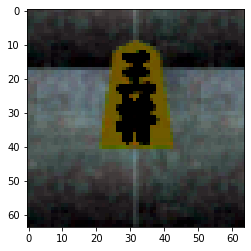

圖片尺寸 :  torch.Size([3, 64, 64])
機器人需移動到的座標(w,h)為 =  [(2101, 737)]


In [6]:
################################### 檔案預處理 ##################################

# preprocess 1
abs_list = []; # absolute coordinates (w, h)
crop_size = (400, 400); # image size (w, h)

# preprocess 2
img_size = 64;
preprocess_2 = transforms.Compose([transforms.Resize([img_size, img_size]),
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = ([0.8763, 0.8272, 0.7882]), 
                                                        std = (0.1465, 0.1530, 0.1693))]);

dataset = DataSet();

# 求mean與std
if (0) :
  loader = DataLoader(dataset, batch_size = 8, shuffle = True);
  num_figure = len(toys_numpy);
  figure_size = img_size;
  mean = 0;
  std = 0;
  for imgs, _ in loader :
    bplus = torch.stack([img_t for img_t in imgs], dim=3).view(3, -1);
    mean += bplus.sum(dim=1);
    std += torch.mul(bplus,bplus).sum(dim=1);
  toys_mean = mean / (figure_size * figure_size * num_figure);
  toys_std = torch.sqrt(std / (figure_size * figure_size * num_figure) - torch.mul(toys_mean, toys_mean));
  print("mean = ", toys_mean);
  print("std = ", toys_std);

# 把資料集分成訓練資料集(8成)和驗證資料集(2成)
train_data_size = int(len(dataset) * 0.8);
valid_data_size = len(dataset) - train_data_size;
train_data, valid_data = random_split(dataset, [train_data_size, valid_data_size]);

# 畫圖測試
a = train_data[1][0];
plt.imshow(a.permute(1,2,0));
plt.show();
print("圖片尺寸 : ", a.shape);
print("機器人需移動到的座標(w,h)為 = ", abs_list);

In [7]:
################################## 定義神經網路 #################################

class DropoutNet(nn.Module) :
  def __init__(self, n_channels = 32) :
    super().__init__();
    self.n_channels = n_channels;
    self.conv1 = nn.Conv2d(3, n_channels, kernel_size=5, padding=2); # nn.Conv2d(輸入通道, 輸出通道, 卷積核, 填補邊界);
    self.conv2 = nn.Conv2d(n_channels, n_channels//2 ,kernel_size=3,padding=1); # // 取整除 => 返回商的整数部分（向下取整） 
    self.conv3 = nn.Conv2d(n_channels//2, (n_channels//2)//2 ,kernel_size=3,padding=1);

    self.pool = nn.MaxPool2d(2);
    self.poo2 = nn.MaxPool2d(2);
    self.poo3 = nn.MaxPool2d(2);

    self.conv1_dropout = nn.Dropout2d(p = 0.4); # 個別神經元被丟棄的機率為0.4，換言之，經過dropout處理後，只會留下大約60%的神經元，且每一次留下的神經元基本上是不相同的
    self.conv2_dropout = nn.Dropout2d(p = 0.4);

    self.act = nn.ReLU();

    self.fc1 = nn.Linear((n_channels//2)//2 * 8 * 8, 64); # nn.Linear(輸入特徵數, 隱藏層大小(輸出層)); 輸入特徵數 = 圖片大小 * 通道數
    self.fc2 = nn.Linear(64, 32);
    self.fc3 = nn.Linear(32, len(ans_type_numpy));
  def forward(self, x) :
    out = self.pool(self.act(self.conv1(x)));
    out = self.conv1_dropout(out);
    out = self.poo2(self.act(self.conv2(out)));
    out = self.conv2_dropout(out);
    out = self.poo3(self.act(self.conv3(out)));
    out = out.view(-1, (self.n_channels//2)//2 * 8 * 8); # 轉換為 B 個 N(圖片大小 * 通道數) 維向量，因為不確定每一次樣本數量(B)會是多少，所以將批次的維度數量設為-1
    out = self.act(self.fc1(out));
    out = self.fc2(out);
    out = self.fc3(out);
    return out;

class BatchNormNet(nn.Module) :
  def __init__(self, n_channels = 32) :
    super().__init__();
    self.n_channels = n_channels;
    self.conv1 = nn.Conv2d(3, n_channels, kernel_size=5, padding=2); # nn.Conv2d(輸入通道, 輸出通道, 卷積核, 填補邊界);
    self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1); # // 取整除 => 返回商的整数部分（向下取整） 
    self.conv3 = nn.Conv2d(n_channels//2, (n_channels//2)//2, kernel_size=3, padding=1);

    self.pool = nn.MaxPool2d(2);
    self.poo2 = nn.MaxPool2d(2);
    self.poo3 = nn.MaxPool2d(2);

    self.act = nn.ReLU();
    
    self.conv1_batchnorm = nn.BatchNorm2d(num_features = n_channels);
    self.conv2_batchnorm = nn.BatchNorm2d(num_features = (n_channels//2));
    self.conv3_batchnorm = nn.BatchNorm2d(num_features = ((n_channels//2)//2));

    self.fc1 = nn.Linear((n_channels//2)//2 * 8 * 8, 64); # nn.Linear(輸入特徵數, 隱藏層大小(輸出層)); 輸入特徵數 = 圖片大小 * 通道數
    self.fc2 = nn.Linear(64, 32);
    self.fc3 = nn.Linear(32, len(ans_type_numpy));
  def forward(self, x) :
    out = self.conv1_batchnorm(self.conv1(x));
    out = self.pool(self.act(out));
    out = self.conv2_batchnorm(self.conv2(out));
    out = self.poo2(self.act(out));
    out = self.conv3_batchnorm(self.conv3(out));
    out = self.poo3(self.act(out));
    out = out.view(-1, (self.n_channels//2)//2 * 8 * 8); # 轉換為 B 個 N(圖片大小 * 通道數) 維向量，因為不確定每一次樣本數量(B)會是多少，所以將批次的維度數量設為-1
    out = self.act(self.fc1(out));
    out = self.fc2(out);
    out = self.fc3(out);
    return out;

In [8]:
################################## 訓練神經網路 #################################

# 定義訓練迴圈
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader) :
  
  train_loss_list = [];
  train_accuracy_list = [];
  val_loss_list = [];
  val_accuracy_list = [];
  for epoch in range (1, n_epochs + 1) :

    # train
    loss_train = 0.0;
    total_train = 0.0;
    correct_train = 0.0;
    model.train(); # 訓練模式使用.train()
    for imgs, labels in train_loader : # 走訪 train_loader，每次會取出一批次的訓練資料及標籤
      
      outputs = model(imgs); # 將一批次資料餵入模型中
      loss = loss_fn(outputs, labels); # 計算損失 (最小化的目標)
      optimizer.zero_grad(); # 將上一輪的梯度清除
      loss.backward(); # 反向運行一次，以便取得損失對所有可訓練參數的梯度
      optimizer.step(); # 更新模型參數
      loss_train += loss.item(); # 將此次訓練週期的所有損失加總起來 (必須用item()將損失轉換為數字)

      _, predicted = torch.max(outputs, dim=1); # 取得最大值所在的索引，並存進predicted陣列
      correct_train += int((predicted == labels).sum()); # 比較預測陣列與標籤陣列，進而得到一個布林陣列;接著，算出該批次中有多少預測是正確的
      total_train += labels.shape[0]; # 計算一共有多少樣本

    train_loss_list.append(loss_train/len(train_loader));
    train_accuracy_list.append(correct_train/total_train);

    # validation
    loss_val = 0.0;
    total_val = 0.0;
    correct_val = 0.0;
    model.eval(); # 測試模型使用.eval()
    for imgs, labels in val_loader : # 走訪 val_loader，每次會取出一批次的驗證資料及標籤
      
      outputs = model(imgs); # 將一批次資料餵入模型中
      loss = loss_fn(outputs, labels); # 計算損失 (最小化的目標)
      loss_val += loss.item(); # 將此次訓練週期的所有損失加總起來 (必須用item()將損失轉換為數字)

      _, predicted = torch.max(outputs, dim=1); # 取得最大值所在的索引，並存進predicted陣列
      correct_val += int((predicted == labels).sum()); # 比較預測陣列與標籤陣列，進而得到一個布林陣列;接著，算出該批次中有多少預測是正確的
      total_val += labels.shape[0]; # 計算一共有多少樣本

    val_loss_list.append(loss_val / len(val_loader));
    val_accuracy_list.append(correct_val / total_val);

    if epoch == 1 or epoch % 10 == 0 :
      print('{} Epoch {}, Traning loss {}, Val loss {}'.format(datetime.datetime.now(), epoch, 
                                                               loss_train / len(train_loader), 
                                                               loss_val / len(val_loader))); # 將損失總和除以批次量(len(train_loader))，以取得每批次的平均損失(相較於總和，以平均值來測量損失更加直觀)
  return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list;


# 先將資料集隨機洗牌，然後每次讀取時會由其中抽取一批次(64筆)的資料
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True);
val_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64, shuffle = False);

if (net_type == 1) :
  model =  DropoutNet(); # 建立模型
elif (net_type == 2) :
  model =  BatchNormNet(); # 建立模型

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3);
loss_fn = nn.CrossEntropyLoss(); # 7.10節中提過的交叉熵損失函數

n_epochs = 300;
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = training_loop(n_epochs, 
                                                                                       optimizer = optimizer, 
                                                                                       model = model, 
                                                                                       loss_fn = loss_fn, 
                                                                                       train_loader = train_loader, 
                                                                                       val_loader = val_loader);

2023-01-10 17:21:28.256509 Epoch 1, Traning loss 1.390555167198181, Val loss 1.4039875268936157
2023-01-10 17:27:06.853202 Epoch 10, Traning loss 1.280777597427368, Val loss 1.323934257030487
2023-01-10 17:33:20.640750 Epoch 20, Traning loss 0.9935966849327087, Val loss 1.354475975036621
2023-01-10 17:39:34.577732 Epoch 30, Traning loss 0.5291108787059784, Val loss 1.8890095949172974
2023-01-10 17:45:51.445201 Epoch 40, Traning loss 0.2594619125127792, Val loss 3.785410165786743
2023-01-10 17:52:05.319483 Epoch 50, Traning loss 0.16903493851423262, Val loss 4.542012929916382
2023-01-10 17:58:25.622765 Epoch 60, Traning loss 0.038154549151659015, Val loss 6.4865899085998535
2023-01-10 18:04:41.632813 Epoch 70, Traning loss 0.13229546919465066, Val loss 5.921361923217773
2023-01-10 18:10:57.558815 Epoch 80, Traning loss 0.027484880201518534, Val loss 5.782836437225342
2023-01-10 18:17:16.170824 Epoch 90, Traning loss 0.00417156252078712, Val loss 7.677535057067871
2023-01-10 18:23:33.241

In [9]:
################################## 儲存模型參數 #################################

if (1) :
  numel_list = [p.numel() for p in model.parameters()];
  print("模型內部的參數數量 = ", sum(numel_list));
  print(numel_list);

  if (net_type == 1) :
    Net_name = "DropoutNet";
  elif (net_type == 2) :
    Net_name = "BatchNormNet";
  
  torch.save(model.state_dict(), fpath + "/result/" + Net_name + ".pt");
  loaded_model =  model;
  loaded_model.load_state_dict(torch.load(fpath + "/result/" + Net_name + ".pt"));
  print(loaded_model);

模型內部的參數數量 =  43260
[2400, 32, 4608, 16, 1152, 8, 32768, 64, 2048, 32, 128, 4]
DropoutNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (poo2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (poo3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (act): ReLU()
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


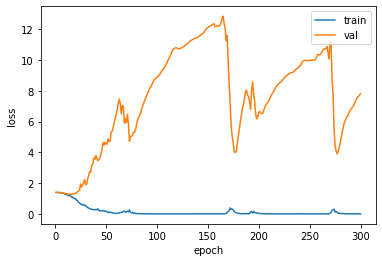

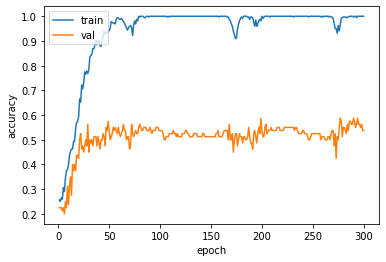

'\nplt.figure(3); plt.clf;\nplt.xlabel("epoch");\nplt.ylabel("loss & accuracy");\nplt.plot(epoch, train_loss_list, label = "train loss");\nplt.plot(epoch, train_accuracy_list, label = "train acc");\nplt.plot(epoch, val_loss_list,label = "val loss");\nplt.plot(epoch, val_accuracy_list, label = "val acc");\nplt.legend(loc = "upper right");\nplt.savefig(fpath + "/result/" + Net_name + ".png");\nplt.show();\n'

In [10]:
###################################### 畫圖 ####################################

epoch = np.arange(1, n_epochs + 1);
# 訓練損失
plt.figure(1); plt.clf;
plt.xlabel("epoch");
plt.ylabel("loss");
plt.plot(epoch, train_loss_list, label = "train");
plt.plot(epoch, val_loss_list, label = "val");
plt.legend(loc = "upper right");
plt.savefig(fpath + "/result/" + Net_name + "_loss.png");
plt.show();

plt.figure(2); plt.clf;
plt.xlabel("epoch");
plt.ylabel("accuracy");
plt.plot(epoch, train_accuracy_list, label = "train");
plt.plot(epoch, val_accuracy_list, label = "val");
plt.legend(loc = "upper left");
plt.savefig(fpath + "/result/" + Net_name + "_accuracy.png");
plt.show();

"""
plt.figure(3); plt.clf;
plt.xlabel("epoch");
plt.ylabel("loss & accuracy");
plt.plot(epoch, train_loss_list, label = "train loss");
plt.plot(epoch, train_accuracy_list, label = "train acc");
plt.plot(epoch, val_loss_list,label = "val loss");
plt.plot(epoch, val_accuracy_list, label = "val acc");
plt.legend(loc = "upper right");
plt.savefig(fpath + "/result/" + Net_name + ".png");
plt.show();
"""